In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle

2023-02-07 08:50:08.256042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Load datasets and standardize data

In [2]:
def load_dataset(dsname):
    metadata = pd.read_csv(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/metadata_final.csv")
    x = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data0.p", "rb" ))
    y = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_labels.p", "rb" ))
    return metadata, x, y

In [3]:
from sklearn.preprocessing import StandardScaler

datasets = ["emodb", "emovo", "ravdess"]
scalers = {d: StandardScaler() for d in datasets}

data = {}
for d in datasets:
    md, x, y = load_dataset(d)
    data[d] = {}
    # standardize data
    n = x.shape
    data[d]["x"] = scalers[d].fit_transform(x.reshape(n[0],-1)).reshape(n)
    data[d]["y"] = y
    data[d]["metadata"] = md

In [4]:
data['emodb']['metadata'].head()

,path,filename,chunk,label,actor,gender,mod
0,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,0
1,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,0
2,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1
3,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,1,sad,13,f,1
4,/datasets/nicolas_facchinetti/emodb/data/13a05...,13a05Tc.wav,0,sad,13,f,1


Get train/test data

In [5]:
from sklearn.model_selection import train_test_split

train = {}
test = {}
test_md = {}
for d in datasets:
    train[d] = {}
    test[d] = {}
    train_df, test_df = train_test_split(data[d]['metadata'], 
                                       test_size = 0.2, 
                                       random_state = 1938,
                                       stratify = data[d]['metadata']['label'])
    test_md[d] = test_df.reset_index()
    train_index = train_df.index
    test_index = test_df.index
    print(f'For {d}:\ttrain size {len(train_index)}, test size {len(test_index)}')
    train[d]['x'] = data[d]['x'][train_index]
    train[d]['y'] = data[d]['y'][train_index]
    test[d]['x']= data[d]['x'][test_index]
    test[d]['y']= data[d]['y'][test_index]
    

For emodb:	train size 3344, test size 837
For emovo:	train size 3944, test size 987
For ravdess:	train size 7161, test size 1791


In [6]:
for d in datasets:
    print(f'For {d} the gender balance in test set is\n{test_md[d].gender.value_counts()}\n')

For emodb the gender balance in test set is
f    522
m    315
Name: gender, dtype: int64

For emovo the gender balance in test set is
f    499
m    488
Name: gender, dtype: int64

For ravdess the gender balance in test set is
f    896
m    895
Name: gender, dtype: int64



In [7]:
test_md['emodb'].head()

,index,path,filename,chunk,label,actor,gender,mod
0,2272,/datasets/nicolas_facchinetti/emodb/data/08b03...,08b03Tc.wav,2,sad,8,f,0
1,1115,/datasets/nicolas_facchinetti/emodb/data/14a07...,14a07Tc.wav,0,sad,14,f,2
2,4069,/datasets/nicolas_facchinetti/emodb/data/16b01...,16b01Tb.wav,1,sad,16,f,2
3,3325,/datasets/nicolas_facchinetti/emodb/data/16a07...,16a07Fb.wav,0,happy,16,f,2
4,3585,/datasets/nicolas_facchinetti/emodb/data/14a07...,14a07Fd.wav,0,happy,14,f,1


In [8]:
def get_m_f_data(md):
    m = md[md.gender=='m'].index
    f = md[md.gender=='f'].index
    return m, f

In [9]:
test_mf = {}
for d in datasets:
    data_d = get_m_f_data(test_md[d])
    print(f"For {d}\n\tmale:{data_d[0].shape[0]}\n\tfemale:{data_d[1].shape[0]}\n")

For emodb
	male:315
	female:522

For emovo
	male:488
	female:499

For ravdess
	male:895
	female:896



Load best parameter for each dataset

In [10]:
import keras_tuner as kt
param = pickle.load(open('/datasets/nicolas_facchinetti/param.p', "rb" ))
param  

{'emodb': {'dropout': 0.3,
  'lstm_dropout': 0.2,
  'learning_rate': 0.001,
  'batch_size': 32,
  'tuner/epochs': 120,
  'tuner/initial_epoch': 8,
  'tuner/bracket': 1,
  'tuner/round': 1,
  'tuner/trial_id': '0050',
  'lstm_units': 2},
 'emovo': {'dropout': 0.3,
  'lstm_dropout': 0.0,
  'learning_rate': 0.0001,
  'batch_size': 8,
  'tuner/epochs': 120,
  'tuner/initial_epoch': 8,
  'tuner/bracket': 1,
  'tuner/round': 1,
  'tuner/trial_id': '0001',
  'lstm_units': 2},
 'ravdess': {'dropout': 0.6,
  'lstm_dropout': 0.2,
  'learning_rate': 0.001,
  'batch_size': 128,
  'tuner/epochs': 120,
  'tuner/initial_epoch': 0,
  'tuner/bracket': 0,
  'tuner/round': 0,
  'lstm_units': 2}}

# Model definition

In [11]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

In [13]:
def get_m(best_param):
    # Define hyper model architecture
    m = Sequential([
        InputLayer(input_shape=(261,128,1)),
        Reshape((9,29,128,1)),
        TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        TimeDistributed(Flatten()),
        
        Dropout(best_param['dropout']),
        
        Bidirectional(LSTM(256, dropout=best_param['lstm_dropout'], return_sequences=False)),
        Dense(5, activation='softmax')
    ])
    
    lr = best_param['learning_rate']
    
    # Define optimizer, loss, and metrics
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    return m

Models training

In [14]:
models = {}
for d in param:
    m = get_m(param[d])

    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')
    
    print(f'Training on {d} dataset')
    history = m.fit(train[d]['x'], train[d]['y'],
                    epochs=100,
                    batch_size=param[d]["batch_size"],
                    validation_split=0.2,
                    callbacks=[earlyStopping, reduce_lr_loss], verbose=2)
    print("\n\n\n")
    
    models[d] = m

2023-01-31 11:24:32.910068: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-31 11:24:32.911113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-31 11:24:33.020015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2023-01-31 11:24:33.020062: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-31 11:24:33.022346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-31 11:24:33.022409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-0

Training on emodb dataset


2023-01-31 11:24:34.237005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-31 11:24:34.253302: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/100


2023-01-31 11:24:36.032888: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-31 11:24:36.211459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


84/84 - 5s - loss: 1.1708 - accuracy: 0.5275 - val_loss: 1.4491 - val_accuracy: 0.4425
Epoch 2/100
84/84 - 1s - loss: 0.6891 - accuracy: 0.7271 - val_loss: 1.0118 - val_accuracy: 0.6024
Epoch 3/100
84/84 - 1s - loss: 0.4921 - accuracy: 0.8138 - val_loss: 0.7424 - val_accuracy: 0.7309
Epoch 4/100
84/84 - 1s - loss: 0.3770 - accuracy: 0.8650 - val_loss: 0.5409 - val_accuracy: 0.7743
Epoch 5/100
84/84 - 1s - loss: 0.2697 - accuracy: 0.9058 - val_loss: 0.3492 - val_accuracy: 0.8729
Epoch 6/100
84/84 - 1s - loss: 0.1779 - accuracy: 0.9477 - val_loss: 0.3054 - val_accuracy: 0.8924
Epoch 7/100
84/84 - 1s - loss: 0.1351 - accuracy: 0.9622 - val_loss: 0.2732 - val_accuracy: 0.9028
Epoch 8/100
84/84 - 1s - loss: 0.0833 - accuracy: 0.9817 - val_loss: 0.2715 - val_accuracy: 0.8999
Epoch 9/100
84/84 - 1s - loss: 0.0687 - accuracy: 0.9854 - val_loss: 0.2786 - val_accuracy: 0.9028
Epoch 10/100
84/84 - 1s - loss: 0.0430 - accuracy: 0.9903 - val_loss: 0.2879 - val_accuracy: 0.8999
Epoch 11/100
84/84 - 

Epoch 23/100
45/45 - 2s - loss: 0.0726 - accuracy: 0.9784 - val_loss: 0.2911 - val_accuracy: 0.9114
Epoch 24/100
45/45 - 2s - loss: 0.0644 - accuracy: 0.9818 - val_loss: 0.2802 - val_accuracy: 0.9197
Epoch 25/100
45/45 - 2s - loss: 0.0567 - accuracy: 0.9838 - val_loss: 0.3051 - val_accuracy: 0.9100
Epoch 26/100
45/45 - 2s - loss: 0.0632 - accuracy: 0.9811 - val_loss: 0.2689 - val_accuracy: 0.9197
Epoch 27/100
45/45 - 2s - loss: 0.0547 - accuracy: 0.9848 - val_loss: 0.2741 - val_accuracy: 0.9170
Epoch 28/100
45/45 - 2s - loss: 0.0537 - accuracy: 0.9852 - val_loss: 0.2486 - val_accuracy: 0.9232
Epoch 29/100
45/45 - 2s - loss: 0.0475 - accuracy: 0.9864 - val_loss: 0.2958 - val_accuracy: 0.9170
Epoch 30/100
45/45 - 2s - loss: 0.0429 - accuracy: 0.9888 - val_loss: 0.2802 - val_accuracy: 0.9142
Epoch 31/100
45/45 - 2s - loss: 0.0455 - accuracy: 0.9869 - val_loss: 0.2807 - val_accuracy: 0.9107
Epoch 32/100
45/45 - 2s - loss: 0.0450 - accuracy: 0.9873 - val_loss: 0.2480 - val_accuracy: 0.9323


Model testing

In [15]:
for d in models:
    loss, accuracy = models[d].evaluate(test[d]['x'], test[d]['y'], batch_size=param[d]["batch_size"])
    print(f'For {d} test loss: {loss} accuracy: {accuracy}')

27/27 [==============================] - 0s 8ms/step - loss: 0.3170 - accuracy: 0.9092
For emodb test loss: 0.31697770953178406 accuracy: 0.9091995358467102
124/124 [==============================] - 1s 5ms/step - loss: 0.3912 - accuracy: 0.8723
For emovo test loss: 0.3912019729614258 accuracy: 0.8723404407501221
14/14 [==============================] - 0s 17ms/step - loss: 0.3132 - accuracy: 0.9107
For ravdess test loss: 0.3131626844406128 accuracy: 0.910664439201355


In [80]:
for m in models:
    models[m].save(f'/datasets/nicolas_facchinetti/models/{m}')

2023-01-31 17:33:54.069404: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /datasets/nicolas_facchinetti/models/emodb/assets


INFO:tensorflow:Assets written to: /datasets/nicolas_facchinetti/models/emodb/assets


INFO:tensorflow:Assets written to: /datasets/nicolas_facchinetti/models/emovo/assets


INFO:tensorflow:Assets written to: /datasets/nicolas_facchinetti/models/emovo/assets


INFO:tensorflow:Assets written to: /datasets/nicolas_facchinetti/models/ravdess/assets


INFO:tensorflow:Assets written to: /datasets/nicolas_facchinetti/models/ravdess/assets


# ART Model

Load pre trained model for results reproducibility

In [12]:
models = {d: tf.keras.models.load_model(f'/datasets/nicolas_facchinetti/models/{d}')
          for d in datasets}

2023-02-07 08:50:17.286121: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-07 08:50:17.286970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-07 08:50:17.375618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2023-02-07 08:50:17.375646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-07 08:50:17.377051: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-07 08:50:17.377122: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-0

In [13]:
for d in models:
    loss, accuracy = models[d].evaluate(test[d]['x'], test[d]['y'], batch_size=param[d]["batch_size"])
    print(f'For {d} test loss: {loss} accuracy: {accuracy}')

2023-02-07 08:50:28.218034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-07 08:50:28.233806: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz
2023-02-07 08:50:28.985117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-07 08:50:29.188051: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


27/27 [==============================] - 2s 7ms/step - loss: 0.3170 - accuracy: 0.9092
For emodb test loss: 0.31697770953178406 accuracy: 0.9091995358467102
124/124 [==============================] - 1s 5ms/step - loss: 0.3912 - accuracy: 0.8723
For emovo test loss: 0.3912019729614258 accuracy: 0.8723404407501221
14/14 [==============================] - 1s 18ms/step - loss: 0.3132 - accuracy: 0.9107
For ravdess test loss: 0.3131626844406128 accuracy: 0.910664439201355


Find max and min value for each dataset to use as clip values for attacks (strictly needed for black box)

In [14]:
minv = np.array([data[d]['x'].min() for d in models])
minv = {d: v for v, d in zip(np.floor(minv), models)}

maxv = np.array([data[d]['x'].max() for d in models])
maxv = {d: v for v, d in zip(np.ceil(maxv), models)}
minv, maxv

({'emodb': -5.0, 'emovo': -3.0, 'ravdess': -2.0},
 {'emodb': 7.0, 'emovo': 7.0, 'ravdess': 8.0})

Make ART model

In [15]:
from art.estimators.classification import TensorFlowV2Classifier
classifiers = {d: TensorFlowV2Classifier(models[d],
                                         nb_classes=5,
                                         input_shape=(261,128,1),
                                         loss_object=tf.keras.losses.SparseCategoricalCrossentropy(),
                                         clip_values=(minv[d], maxv[d]),
                                         channels_first=False)
               for d in models}

/home/nicolas/.conda/envs/thesis/lib/python3.9/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


Model attack function

In [16]:
import time

def do_attack(method, X):
    start = time.time()
    x_adv = method.generate(X, verbose=True)
    elapsed = time.time() - start
    print(f'Attack get {elapsed} seconds to complete')
    return x_adv, elapsed

In [17]:
def evaluate_attack(model, test_samples, test_metadata, x_adv):
    mi, fi = get_m_f_data(test_metadata)
    x = test_samples['x']
    y = test_samples['y']
    
    def evaluate_on_samples(model, adv, x, y):
        loss, accuracy = model.evaluate(adv, y, batch_size=param[d]["batch_size"], verbose=0)
        perturbation = np.mean(np.abs((adv - x)))
        print(f'\t\tloss: {loss:.5f}, accuracy: {accuracy:.5f}, avg perturbation: {perturbation:.5f}\n')
        return loss, accuracy, perturbation
    
    print('\tWhole test set')
    l1, a1, p1 = evaluate_on_samples(model, x_adv, x, y)
    print('\tOnly male data')
    l2, a2, p2 = evaluate_on_samples(model, x_adv[mi], x[mi], y[mi])
    print('\tOnly female data')
    l3, a3, p3 = evaluate_on_samples(model, x_adv[fi], x[fi], y[fi])
    
    def make_dict(v):
        return {'All': v[0], 'Male': v[1], 'Female': v[2]}
    
    res_dict = {'Loss': make_dict([l1,l2,l3]),
                'Accuracy': make_dict([a1,a2,a3]),
                'Perturbation': make_dict([p1,p2,p3])}
    return res_dict

In [18]:
def attack(attacks_confs, name):
    # save results for dataframe output
    results[name] = {}
    times[name] = {}
    
    # return to store adv generated
    adv_generated = {}
    adv_generated[name] = {}
    for d in attacks_confs:
        results[name][d] = {}
        times[name][d] = {}
        adv_generated[name][d] = {}
        for p in attacks_confs[d]:
            print(f'Attacking {d} with {name}, parameter {p}')
            
            # compute adv examples and get time
            x_adv, time = do_attack(attacks_confs[d][p], test[d]['x'])
            # test adv examples on whole data, only M, and only F
            res = evaluate_attack(models[d], test[d], test_md[d], x_adv)
            
            results[name][d][p] = res
            times[name][d][p] = time
            adv_generated[name][d][p] = x_adv
            
        print("_____________________________")
    return adv_generated

Functions to display data in DataFrame

In [19]:
def df_attack(d_res):
    reform = {(dataset, param, metric): values
              for dataset, inner1 in d_res.items()
              for param, inner2 in inner1.items()
              for metric, values in inner2.items()
              if metric != 'Loss'}
    mux = pd.MultiIndex.from_tuples(reform.keys())
    df = pd.DataFrame(list(reform.values()), index=mux)
    return df

def df_time(d_res):
    reform = {(dataset, param): value
              for dataset, inner1 in d_res.items()
              for param, value in inner1.items()}
    mux = pd.MultiIndex.from_tuples(reform.keys())
    df = pd.DataFrame(list(reform.values()), index=mux, columns=['Time'])
    return df

In [20]:
def save_adv(data):
    for attack in data:
        pickle.dump(data[attack],
                    open(f'/datasets/nicolas_facchinetti/adv/{attack}.p', "wb"))
    

In [21]:
# size of the batch on which adversarial samples are generated.
bs = 256
# store accuracy, loss and perturbation levels
results = {}
# store time to generate the samples
times = {}

# White Box attack

In [22]:
from art.attacks.evasion import FastGradientMethod

epss = [0.25, 0.5, 0.75, 1, 1.25]
conf1 = {d: {e: FastGradientMethod(estimator=classifiers[d],
                                   eps=e,
                                   batch_size=bs)
             for e in epss}
         for d in datasets}

adv = attack(conf1, 'fgsm')
save_adv(adv)

Attacking emodb with fgsm, parameter 0.25
Attack get 1.8857271671295166 seconds to complete
	Whole test set
		loss: 6.30714, accuracy: 0.17085, avg perturbation: 0.21394

	Only male data
		loss: 7.19170, accuracy: 0.11429, avg perturbation: 0.21370

	Only female data
		loss: 5.77336, accuracy: 0.20498, avg perturbation: 0.21408

Attacking emodb with fgsm, parameter 0.5
Attack get 1.1694109439849854 seconds to complete
	Whole test set
		loss: 6.75276, accuracy: 0.12784, avg perturbation: 0.42787

	Only male data
		loss: 7.42255, accuracy: 0.09524, avg perturbation: 0.42739

	Only female data
		loss: 6.34857, accuracy: 0.14751, avg perturbation: 0.42816

Attacking emodb with fgsm, parameter 0.75
Attack get 1.2775695323944092 seconds to complete
	Whole test set
		loss: 6.44006, accuracy: 0.11470, avg perturbation: 0.64181

	Only male data
		loss: 6.88370, accuracy: 0.09206, avg perturbation: 0.64109

	Only female data
		loss: 6.17236, accuracy: 0.12835, avg perturbation: 0.64224

Attackin

In [39]:
df_attack(results['fgsm'])

All      Male    Female
emodb   0.25 Accuracy      0.170848  0.114286  0.204981
             Perturbation  0.213936  0.213697  0.214081
        0.50 Accuracy      0.127838  0.095238  0.147510
             Perturbation  0.427872  0.427394  0.428161
        0.75 Accuracy      0.114695  0.092063  0.128352
             Perturbation  0.641809  0.641091  0.642243
        1.00 Accuracy      0.112306  0.092063  0.124521
             Perturbation  0.855744  0.854788  0.856322
        1.25 Accuracy      0.108722  0.088889  0.120690
             Perturbation  1.069678  1.068483  1.070397
emovo   0.25 Accuracy      0.072948  0.061475  0.084168
             Perturbation  0.218117  0.218172  0.218063
        0.50 Accuracy      0.069909  0.061475  0.078156
             Perturbation  0.436233  0.436344  0.436126
        0.75 Accuracy      0.075988  0.067623  0.084168
             Perturbation  0.654351  0.654515  0.654188
        1.00 Accuracy      0.077001  0.067623  0.086172
             Perturbation  0.872439  0.872658  0.872231
        1.25 Accuracy      0.081054  0.075820  0.086172
             Perturbation  1.090331  1.090594  1.090074
ravdess 0.25 Accuracy      0.145729  0.127374  0.164062
             Perturbation  0.197921  0.191780  0.204056
        0.50 Accuracy      0.188163  0.181006  0.195312
             Perturbation  0.395706  0.383389  0.408010
        0.75 Accuracy      0.203797  0.204469  0.203125
             Perturbation  0.592467  0.573860  0.611054
        1.00 Accuracy      0.207147  0.202235  0.212054
             Perturbation  0.784306  0.758748  0.809839
        1.25 Accuracy      0.198213  0.187709  0.208705
             Perturbation  0.961089  0.926421  0.995723

In [41]:
df_time(times['fgsm'])

Time
emodb   0.25  1.885727
        0.50  1.169411
        0.75  1.277570
        1.00  1.282655
        1.25  1.272061
emovo   0.25  1.753297
        0.50  1.535921
        0.75  1.539335
        1.00  1.536227
        1.25  1.486180
ravdess 0.25  3.149803
        0.50  2.839605
        0.75  2.792259
        1.00  2.863609
        1.25  2.839487

In [23]:
from art.attacks.evasion import BasicIterativeMethod

epss = [0.25, 0.5, 0.75, 1, 1.25]
conf2 = {d: {e: BasicIterativeMethod(estimator=classifiers[d],
                                     eps=e,
                                     eps_step=0.1,
                                     batch_size=bs,
                                     max_iter=100,
                                     verbose=True)
             for e in epss}
         for d in datasets}

adv = attack(conf2, 'bim')
save_adv(adv)

Attacking emodb with bim, parameter 0.25


PGD - Batches: 0it [00:00, ?it/s]

Attack get 24.96191668510437 seconds to complete
	Whole test set
		loss: 23.00672, accuracy: 0.06691, avg perturbation: 0.15904

	Only male data
		loss: 23.38926, accuracy: 0.06984, avg perturbation: 0.15833

	Only female data
		loss: 22.77588, accuracy: 0.06513, avg perturbation: 0.15948

Attacking emodb with bim, parameter 0.5


PGD - Batches: 0it [00:00, ?it/s]

Attack get 24.89863419532776 seconds to complete
	Whole test set
		loss: 29.43054, accuracy: 0.06691, avg perturbation: 0.29291

	Only male data
		loss: 29.61068, accuracy: 0.06984, avg perturbation: 0.29282

	Only female data
		loss: 29.32183, accuracy: 0.06513, avg perturbation: 0.29296

Attacking emodb with bim, parameter 0.75


PGD - Batches: 0it [00:00, ?it/s]

Attack get 24.870096921920776 seconds to complete
	Whole test set
		loss: 31.67983, accuracy: 0.06691, avg perturbation: 0.41762

	Only male data
		loss: 31.72492, accuracy: 0.06984, avg perturbation: 0.41766

	Only female data
		loss: 31.65263, accuracy: 0.06513, avg perturbation: 0.41760

Attacking emodb with bim, parameter 1


PGD - Batches: 0it [00:00, ?it/s]

Attack get 24.799796104431152 seconds to complete
	Whole test set
		loss: 32.77645, accuracy: 0.06691, avg perturbation: 0.52410

	Only male data
		loss: 32.76876, accuracy: 0.06984, avg perturbation: 0.52463

	Only female data
		loss: 32.78111, accuracy: 0.06513, avg perturbation: 0.52378

Attacking emodb with bim, parameter 1.25


PGD - Batches: 0it [00:00, ?it/s]

Attack get 24.750417232513428 seconds to complete
	Whole test set
		loss: 33.36066, accuracy: 0.06691, avg perturbation: 0.60674

	Only male data
		loss: 33.31302, accuracy: 0.06984, avg perturbation: 0.60765

	Only female data
		loss: 33.38940, accuracy: 0.06513, avg perturbation: 0.60619

_____________________________
Attacking emovo with bim, parameter 0.25


PGD - Batches: 0it [00:00, ?it/s]

Attack get 28.622461080551147 seconds to complete
	Whole test set
		loss: 28.10382, accuracy: 0.07599, avg perturbation: 0.15344

	Only male data
		loss: 29.08752, accuracy: 0.06352, avg perturbation: 0.15309

	Only female data
		loss: 27.14181, accuracy: 0.08818, avg perturbation: 0.15377

Attacking emovo with bim, parameter 0.5


PGD - Batches: 0it [00:00, ?it/s]

Attack get 28.520084381103516 seconds to complete
	Whole test set
		loss: 34.02573, accuracy: 0.07599, avg perturbation: 0.28565

	Only male data
		loss: 35.02684, accuracy: 0.06352, avg perturbation: 0.28471

	Only female data
		loss: 33.04668, accuracy: 0.08818, avg perturbation: 0.28657

Attacking emovo with bim, parameter 0.75


PGD - Batches: 0it [00:00, ?it/s]

Attack get 28.501672506332397 seconds to complete
	Whole test set
		loss: 36.02174, accuracy: 0.07599, avg perturbation: 0.40855

	Only male data
		loss: 37.00224, accuracy: 0.06352, avg perturbation: 0.40751

	Only female data
		loss: 35.06285, accuracy: 0.08818, avg perturbation: 0.40957

Attacking emovo with bim, parameter 1


PGD - Batches: 0it [00:00, ?it/s]

Attack get 28.661412954330444 seconds to complete
	Whole test set
		loss: 36.93696, accuracy: 0.07599, avg perturbation: 0.51399

	Only male data
		loss: 37.92979, accuracy: 0.06352, avg perturbation: 0.51276

	Only female data
		loss: 35.96601, accuracy: 0.08818, avg perturbation: 0.51520

Attacking emovo with bim, parameter 1.25


PGD - Batches: 0it [00:00, ?it/s]

Attack get 28.53012704849243 seconds to complete
	Whole test set
		loss: 37.41957, accuracy: 0.07599, avg perturbation: 0.59807

	Only male data
		loss: 38.43127, accuracy: 0.06352, avg perturbation: 0.59668

	Only female data
		loss: 36.43018, accuracy: 0.08818, avg perturbation: 0.59944

_____________________________
Attacking ravdess with bim, parameter 0.25


PGD - Batches: 0it [00:00, ?it/s]

Attack get 51.782495975494385 seconds to complete
	Whole test set
		loss: 32.88740, accuracy: 0.05863, avg perturbation: 0.14736

	Only male data
		loss: 33.73360, accuracy: 0.05698, avg perturbation: 0.14605

	Only female data
		loss: 32.04214, accuracy: 0.06027, avg perturbation: 0.14867

Attacking ravdess with bim, parameter 0.5


PGD - Batches: 0it [00:00, ?it/s]

Attack get 51.778329610824585 seconds to complete
	Whole test set
		loss: 40.24240, accuracy: 0.05863, avg perturbation: 0.27289

	Only male data
		loss: 41.04356, accuracy: 0.05698, avg perturbation: 0.27130

	Only female data
		loss: 39.44213, accuracy: 0.06027, avg perturbation: 0.27449

Attacking ravdess with bim, parameter 0.75


PGD - Batches: 0it [00:00, ?it/s]

Attack get 51.793720960617065 seconds to complete
	Whole test set
		loss: 42.70686, accuracy: 0.05863, avg perturbation: 0.39023

	Only male data
		loss: 43.52699, accuracy: 0.05698, avg perturbation: 0.38828

	Only female data
		loss: 41.88766, accuracy: 0.06027, avg perturbation: 0.39219

Attacking ravdess with bim, parameter 1


PGD - Batches: 0it [00:00, ?it/s]

Attack get 51.86567544937134 seconds to complete
	Whole test set
		loss: 43.86084, accuracy: 0.05863, avg perturbation: 0.48458

	Only male data
		loss: 44.71799, accuracy: 0.05698, avg perturbation: 0.48168

	Only female data
		loss: 43.00463, accuracy: 0.06027, avg perturbation: 0.48747

Attacking ravdess with bim, parameter 1.25


PGD - Batches: 0it [00:00, ?it/s]

Attack get 51.974019050598145 seconds to complete
	Whole test set
		loss: 44.53680, accuracy: 0.05863, avg perturbation: 0.54685

	Only male data
		loss: 45.39465, accuracy: 0.05698, avg perturbation: 0.54163

	Only female data
		loss: 43.67991, accuracy: 0.06027, avg perturbation: 0.55208

_____________________________


In [42]:
df_attack(results['bim'])

All      Male    Female
emodb   0.25 Accuracy      0.066906  0.069841  0.065134
             Perturbation  0.159043  0.158326  0.159476
        0.50 Accuracy      0.066906  0.069841  0.065134
             Perturbation  0.292908  0.292819  0.292962
        0.75 Accuracy      0.066906  0.069841  0.065134
             Perturbation  0.417621  0.417656  0.417599
        1.00 Accuracy      0.066906  0.069841  0.065134
             Perturbation  0.524102  0.524633  0.523783
        1.25 Accuracy      0.066906  0.069841  0.065134
             Perturbation  0.606741  0.607653  0.606190
emovo   0.25 Accuracy      0.075988  0.063525  0.088176
             Perturbation  0.153438  0.153094  0.153774
        0.50 Accuracy      0.075988  0.063525  0.088176
             Perturbation  0.285646  0.284706  0.286565
        0.75 Accuracy      0.075988  0.063525  0.088176
             Perturbation  0.408552  0.407514  0.409566
        1.00 Accuracy      0.075988  0.063525  0.088176
             Perturbation  0.513995  0.512762  0.515199
        1.25 Accuracy      0.075988  0.063525  0.088176
             Perturbation  0.598073  0.596679  0.599436
ravdess 0.25 Accuracy      0.058626  0.056983  0.060268
             Perturbation  0.147361  0.146052  0.148669
        0.50 Accuracy      0.058626  0.056983  0.060268
             Perturbation  0.272894  0.271299  0.274486
        0.75 Accuracy      0.058626  0.056983  0.060268
             Perturbation  0.390233  0.388277  0.392189
        1.00 Accuracy      0.058626  0.056983  0.060268
             Perturbation  0.484575  0.481676  0.487472
        1.25 Accuracy      0.058626  0.056983  0.060268
             Perturbation  0.546854  0.541625  0.552078

In [43]:
df_time(times['bim'])

Time
emodb   0.25  24.961917
        0.50  24.898634
        0.75  24.870097
        1.00  24.799796
        1.25  24.750417
emovo   0.25  28.622461
        0.50  28.520084
        0.75  28.501673
        1.00  28.661413
        1.25  28.530127
ravdess 0.25  51.782496
        0.50  51.778330
        0.75  51.793721
        1.00  51.865675
        1.25  51.974019

In [24]:
from art.attacks.evasion import DeepFool   

iterations = [1, 5, 20]
conf3 = {d: {i: DeepFool(classifier=classifiers[d],
                         nb_grads=5,
                         epsilon=1e-05,  # to help convergence and avoid being stuck to 0
                         max_iter=i,
                         batch_size=bs,
                         verbose=True)
             for i in iterations}
         for d in datasets}

adv = attack(conf3, 'df')
save_adv(adv)

Attacking emodb with df, parameter 1


DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 4.991265058517456 seconds to complete
	Whole test set
		loss: 5.35166, accuracy: 0.11828, avg perturbation: 1.89471

	Only male data
		loss: 5.79706, accuracy: 0.09841, avg perturbation: 1.85707

	Only female data
		loss: 5.08289, accuracy: 0.13027, avg perturbation: 1.91743

Attacking emodb with df, parameter 5


DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 7.520038604736328 seconds to complete
	Whole test set
		loss: 5.51910, accuracy: 0.06093, avg perturbation: 1.89448

	Only male data
		loss: 5.90949, accuracy: 0.06984, avg perturbation: 1.85798

	Only female data
		loss: 5.28352, accuracy: 0.05556, avg perturbation: 1.91650

Attacking emodb with df, parameter 20


DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 7.356467962265015 seconds to complete
	Whole test set
		loss: 5.51910, accuracy: 0.06093, avg perturbation: 1.89448

	Only male data
		loss: 5.90949, accuracy: 0.06984, avg perturbation: 1.85798

	Only female data
		loss: 5.28352, accuracy: 0.05556, avg perturbation: 1.91650

_____________________________
Attacking emovo with df, parameter 1


DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 5.628634214401245 seconds to complete
	Whole test set
		loss: 5.77441, accuracy: 0.13374, avg perturbation: 1.10543

	Only male data
		loss: 5.99360, accuracy: 0.10041, avg perturbation: 1.19232

	Only female data
		loss: 5.56006, accuracy: 0.16633, avg perturbation: 1.02045

Attacking emovo with df, parameter 5


DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 8.100918531417847 seconds to complete
	Whole test set
		loss: 5.83863, accuracy: 0.08612, avg perturbation: 1.10493

	Only male data
		loss: 6.04008, accuracy: 0.06762, avg perturbation: 1.19205

	Only female data
		loss: 5.64162, accuracy: 0.10421, avg perturbation: 1.01973

Attacking emovo with df, parameter 20


DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 8.345467567443848 seconds to complete
	Whole test set
		loss: 5.83863, accuracy: 0.08612, avg perturbation: 1.10493

	Only male data
		loss: 6.04008, accuracy: 0.06762, avg perturbation: 1.19205

	Only female data
		loss: 5.64162, accuracy: 0.10421, avg perturbation: 1.01973

_____________________________
Attacking ravdess with df, parameter 1


DeepFool:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 10.656574249267578 seconds to complete
	Whole test set
		loss: 5.73832, accuracy: 0.19933, avg perturbation: 1.30782

	Only male data
		loss: 5.78429, accuracy: 0.18883, avg perturbation: 1.22248

	Only female data
		loss: 5.69240, accuracy: 0.20982, avg perturbation: 1.39306

Attacking ravdess with df, parameter 5


DeepFool:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 22.576127290725708 seconds to complete
	Whole test set
		loss: 5.98513, accuracy: 0.05248, avg perturbation: 1.32695

	Only male data
		loss: 6.04907, accuracy: 0.05587, avg perturbation: 1.24268

	Only female data
		loss: 5.92127, accuracy: 0.04911, avg perturbation: 1.41112

Attacking ravdess with df, parameter 20


DeepFool:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 22.583572387695312 seconds to complete
	Whole test set
		loss: 5.98513, accuracy: 0.05248, avg perturbation: 1.32695

	Only male data
		loss: 6.04907, accuracy: 0.05587, avg perturbation: 1.24268

	Only female data
		loss: 5.92126, accuracy: 0.04911, avg perturbation: 1.41112

_____________________________


In [44]:
df_attack(results['df'])

All      Male    Female
emodb   1  Accuracy      0.118280  0.098413  0.130268
           Perturbation  1.894715  1.857067  1.917433
        5  Accuracy      0.060932  0.069841  0.055556
           Perturbation  1.894479  1.857976  1.916505
        20 Accuracy      0.060932  0.069841  0.055556
           Perturbation  1.894479  1.857976  1.916504
emovo   1  Accuracy      0.133739  0.100410  0.166333
           Perturbation  1.105426  1.192315  1.020453
        5  Accuracy      0.086120  0.067623  0.104208
           Perturbation  1.104930  1.192047  1.019734
        20 Accuracy      0.086120  0.067623  0.104208
           Perturbation  1.104930  1.192047  1.019734
ravdess 1  Accuracy      0.199330  0.188827  0.209821
           Perturbation  1.307815  1.222481  1.393056
        5  Accuracy      0.052485  0.055866  0.049107
           Perturbation  1.326945  1.242681  1.411119
        20 Accuracy      0.052485  0.055866  0.049107
           Perturbation  1.326945  1.242681  1.411119

In [45]:
df_time(times['df'])

Time
emodb   1    4.991265
        5    7.520039
        20   7.356468
emovo   1    5.628634
        5    8.100919
        20   8.345468
ravdess 1   10.656574
        5   22.576127
        20  22.583572

In [25]:
from art.attacks.evasion import SaliencyMapMethod

# amount of pertubration
thetas = [-1, -0.5, 0.5, 1]
conf4 = {d: {t: SaliencyMapMethod(classifier=classifiers[d],
                                  theta=t, # amount of perturbation introduced per step
                                  gamma=1, #  maximum fraction of features being perturbed
                                  batch_size=bs,
                                  verbose=True)                           
             for t in thetas}
         for d in datasets}

adv = attack(conf4, 'jsma')
save_adv(adv)

Attacking emodb with jsma, parameter -1


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 360.35500955581665 seconds to complete
	Whole test set
		loss: 0.94758, accuracy: 0.02748, avg perturbation: 0.00596

	Only male data
		loss: 0.96936, accuracy: 0.03492, avg perturbation: 0.00484

	Only female data
		loss: 0.93444, accuracy: 0.02299, avg perturbation: 0.00664

Attacking emodb with jsma, parameter -0.5


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 775.9861149787903 seconds to complete
	Whole test set
		loss: 1.12434, accuracy: 0.03106, avg perturbation: 0.00740

	Only male data
		loss: 1.23186, accuracy: 0.04127, avg perturbation: 0.00644

	Only female data
		loss: 1.05946, accuracy: 0.02490, avg perturbation: 0.00797

Attacking emodb with jsma, parameter 0.5


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 284.88454508781433 seconds to complete
	Whole test set
		loss: 1.05246, accuracy: 0.02867, avg perturbation: 0.00223

	Only male data
		loss: 1.08556, accuracy: 0.02540, avg perturbation: 0.00162

	Only female data
		loss: 1.03248, accuracy: 0.03065, avg perturbation: 0.00260

Attacking emodb with jsma, parameter 1


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 225.94102668762207 seconds to complete
	Whole test set
		loss: 1.24218, accuracy: 0.01314, avg perturbation: 0.00346

	Only male data
		loss: 1.33590, accuracy: 0.01905, avg perturbation: 0.00302

	Only female data
		loss: 1.18562, accuracy: 0.00958, avg perturbation: 0.00372

_____________________________
Attacking emovo with jsma, parameter -1


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 352.77153730392456 seconds to complete
	Whole test set
		loss: 1.12642, accuracy: 0.02938, avg perturbation: 0.00541

	Only male data
		loss: 1.12845, accuracy: 0.01434, avg perturbation: 0.00575

	Only female data
		loss: 1.12445, accuracy: 0.04409, avg perturbation: 0.00507

Attacking emovo with jsma, parameter -0.5


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 488.7124330997467 seconds to complete
	Whole test set
		loss: 1.08529, accuracy: 0.02837, avg perturbation: 0.00330

	Only male data
		loss: 1.06581, accuracy: 0.01844, avg perturbation: 0.00335

	Only female data
		loss: 1.10434, accuracy: 0.03808, avg perturbation: 0.00326

Attacking emovo with jsma, parameter 0.5


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 135.3069474697113 seconds to complete
	Whole test set
		loss: 1.15849, accuracy: 0.03343, avg perturbation: 0.00147

	Only male data
		loss: 1.03554, accuracy: 0.03484, avg perturbation: 0.00137

	Only female data
		loss: 1.27873, accuracy: 0.03206, avg perturbation: 0.00157

Attacking emovo with jsma, parameter 1


JSMA:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 136.0146381855011 seconds to complete
	Whole test set
		loss: 1.29559, accuracy: 0.02229, avg perturbation: 0.00209

	Only male data
		loss: 1.20614, accuracy: 0.02049, avg perturbation: 0.00197

	Only female data
		loss: 1.38307, accuracy: 0.02405, avg perturbation: 0.00220

_____________________________
Attacking ravdess with jsma, parameter -1


JSMA:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 854.1931266784668 seconds to complete
	Whole test set
		loss: 1.03464, accuracy: 0.02401, avg perturbation: 0.00664

	Only male data
		loss: 1.07401, accuracy: 0.01676, avg perturbation: 0.00570

	Only female data
		loss: 0.99531, accuracy: 0.03125, avg perturbation: 0.00758

Attacking ravdess with jsma, parameter -0.5


JSMA:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 1277.6076731681824 seconds to complete
	Whole test set
		loss: 0.98209, accuracy: 0.01787, avg perturbation: 0.00457

	Only male data
		loss: 0.98628, accuracy: 0.02011, avg perturbation: 0.00404

	Only female data
		loss: 0.97790, accuracy: 0.01562, avg perturbation: 0.00511

Attacking ravdess with jsma, parameter 0.5


JSMA:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 623.8252415657043 seconds to complete
	Whole test set
		loss: 1.09361, accuracy: 0.03015, avg perturbation: 0.00198

	Only male data
		loss: 1.13062, accuracy: 0.03128, avg perturbation: 0.00179

	Only female data
		loss: 1.05664, accuracy: 0.02902, avg perturbation: 0.00216

Attacking ravdess with jsma, parameter 1


JSMA:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 374.433349609375 seconds to complete
	Whole test set
		loss: 1.14628, accuracy: 0.01731, avg perturbation: 0.00242

	Only male data
		loss: 1.17533, accuracy: 0.01564, avg perturbation: 0.00190

	Only female data
		loss: 1.11726, accuracy: 0.01897, avg perturbation: 0.00295

_____________________________


In [46]:
df_attack(results['jsma'])

All      Male    Female
emodb   -1.0 Accuracy      0.027479  0.034921  0.022989
             Perturbation  0.005961  0.004842  0.006635
        -0.5 Accuracy      0.031063  0.041270  0.024904
             Perturbation  0.007395  0.006436  0.007974
         0.5 Accuracy      0.028674  0.025397  0.030651
             Perturbation  0.002230  0.001618  0.002600
         1.0 Accuracy      0.013142  0.019048  0.009579
             Perturbation  0.003458  0.003019  0.003723
emovo   -1.0 Accuracy      0.029382  0.014344  0.044088
             Perturbation  0.005406  0.005750  0.005070
        -0.5 Accuracy      0.028369  0.018443  0.038076
             Perturbation  0.003303  0.003347  0.003259
         0.5 Accuracy      0.033435  0.034836  0.032064
             Perturbation  0.001472  0.001371  0.001570
         1.0 Accuracy      0.022290  0.020492  0.024048
             Perturbation  0.002086  0.001973  0.002196
ravdess -1.0 Accuracy      0.024009  0.016760  0.031250
             Perturbation  0.006639  0.005701  0.007576
        -0.5 Accuracy      0.017867  0.020112  0.015625
             Perturbation  0.004571  0.004035  0.005106
         0.5 Accuracy      0.030151  0.031285  0.029018
             Perturbation  0.001975  0.001786  0.002163
         1.0 Accuracy      0.017309  0.015642  0.018973
             Perturbation  0.002424  0.001903  0.002945

In [47]:
df_time(times['jsma'])

Time
emodb   -1.0   360.355010
        -0.5   775.986115
         0.5   284.884545
         1.0   225.941027
emovo   -1.0   352.771537
        -0.5   488.712433
         0.5   135.306947
         1.0   136.014638
ravdess -1.0   854.193127
        -0.5  1277.607673
         0.5   623.825242
         1.0   374.433350

In [29]:
from art.attacks.evasion import CarliniL0Method

cs = [0.01]
conf5 = {d: {c: CarliniL0Method(classifier=classifiers[d],
                                max_iter=10,
                                learning_rate=0.01,
                                binary_search_steps=10,
                                initial_const=c,
                                max_halving=5,
                                max_doubling=5,
                                warm_start=True,
                                batch_size=bs,
                                verbose=True)
             for c in cs}
         for d in datasets}

adv = attack(conf5, 'cwl0')
save_adv(adv)

Attacking emodb with cwl0, parameter 0.01


2023-02-07 03:14:20.762970: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.39GiB (rounded to 1494547200)requested by op ReluGrad
Current allocation summary follows.
2023-02-07 03:14:20.763066: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2023-02-07 03:14:20.763094: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 94, Chunks in use: 94. 23.5KiB allocated for chunks. 23.5KiB in use in bin. 3.1KiB client-requested in use in bin.
2023-02-07 03:14:20.763111: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-02-07 03:14:20.763128: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 37, Chunks in use: 37. 42.2KiB allocated for chunks. 42.2KiB in use in bin. 38.7KiB client-requested in use i

ResourceExhaustedError: OOM when allocating tensor with shape[7533,25,124,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ReluGrad]

In [ ]:
df_attack(results['cwl0'])


In [ ]:
df_time(times['cwl0'])

In [37]:
from art.attacks.evasion import CarliniL2Method

cs = [0.01]
conf6 = {d: {c: CarliniL2Method(classifier=classifiers[d],
                                max_iter=10,
                                learning_rate=0.01,
                                binary_search_steps=20,
                                initial_const=c,
                                max_halving=10,
                                max_doubling=10,
                                batch_size=bs,
                                verbose=True)
             for c in cs}
         for d in datasets}

adv = attack(conf6, 'cwl2')
save_adv(adv)

Attacking emodb with cwl2, parameter 0.01


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 2041.7795732021332 seconds to complete
	Whole test set
		loss: 1.46976, accuracy: 0.18757, avg perturbation: 0.00778

	Only male data
		loss: 1.56691, accuracy: 0.12698, avg perturbation: 0.00717

	Only female data
		loss: 1.41113, accuracy: 0.22414, avg perturbation: 0.00814

_____________________________
Attacking emovo with cwl2, parameter 0.01


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]

Attack get 2338.341061592102 seconds to complete
	Whole test set
		loss: 1.43480, accuracy: 0.09220, avg perturbation: 0.00540

	Only male data
		loss: 1.44228, accuracy: 0.07582, avg perturbation: 0.00568

	Only female data
		loss: 1.42748, accuracy: 0.10822, avg perturbation: 0.00512

_____________________________
Attacking ravdess with cwl2, parameter 0.01


C&W L_2:   0%|          | 0/7 [00:00<?, ?it/s]

Attack get 4650.34329199791 seconds to complete
	Whole test set
		loss: 1.65594, accuracy: 0.12395, avg perturbation: 0.00566

	Only male data
		loss: 1.62848, accuracy: 0.12179, avg perturbation: 0.00490

	Only female data
		loss: 1.68337, accuracy: 0.12612, avg perturbation: 0.00642

_____________________________


In [51]:
df_attack(results['cwl2'])

All      Male    Female
emodb   0.01 Accuracy      0.187575  0.126984  0.224138
             Perturbation  0.007776  0.007170  0.008141
emovo   0.01 Accuracy      0.092199  0.075820  0.108216
             Perturbation  0.005397  0.005678  0.005123
ravdess 0.01 Accuracy      0.123953  0.121788  0.126116
             Perturbation  0.005660  0.004901  0.006418

In [52]:
df_time(times['cwl2'])

,,Time
emodb,0.01,2041.779573
emovo,0.01,2338.341062
ravdess,0.01,4650.343292


In [29]:
from art.attacks.evasion import CarliniLInfMethod

cs = [1e-04]
conf7 = {d: {c: CarliniLInfMethod(classifier=classifiers[d],
                                  max_iter=10,
                                  learning_rate=0.01,
                                  initial_const=c,
                                  largest_const=2e01,
                                  decrease_factor=0.8,
                                  const_factor=4,
                                  batch_size=bs,
                                  verbose=True)
             for c in cs}
         for d in datasets}

adv = attack(conf7, 'cwinf')
save_adv(adv)

Attacking emodb with cwinf, parameter 0.0001


C&W L_inf:   0%|          | 0/837 [00:00<?, ?it/s]

Attack get 4230.924565792084 seconds to complete
	Whole test set
		loss: 3.28424, accuracy: 0.06930, avg perturbation: 0.05251

	Only male data
		loss: 3.44833, accuracy: 0.07619, avg perturbation: 0.05023

	Only female data
		loss: 3.18522, accuracy: 0.06513, avg perturbation: 0.05389

_____________________________
Attacking emovo with cwinf, parameter 0.0001


C&W L_inf:   0%|          | 0/987 [00:00<?, ?it/s]

Attack get 5158.850016593933 seconds to complete
	Whole test set
		loss: 4.35416, accuracy: 0.08511, avg perturbation: 0.03501

	Only male data
		loss: 4.67249, accuracy: 0.06762, avg perturbation: 0.03491

	Only female data
		loss: 4.04285, accuracy: 0.10220, avg perturbation: 0.03510

_____________________________
Attacking ravdess with cwinf, parameter 0.0001


C&W L_inf:   0%|          | 0/1791 [00:00<?, ?it/s]

Attack get 9882.847729444504 seconds to complete
	Whole test set
		loss: 3.35897, accuracy: 0.06030, avg perturbation: 0.02721

	Only male data
		loss: 3.44589, accuracy: 0.05810, avg perturbation: 0.02529

	Only female data
		loss: 3.27215, accuracy: 0.06250, avg perturbation: 0.02912

_____________________________


In [53]:
df_attack(results['cwinf'])

All      Male    Female
emodb   0.0001 Accuracy      0.069295  0.076190  0.065134
               Perturbation  0.052510  0.050230  0.053886
emovo   0.0001 Accuracy      0.085106  0.067623  0.102204
               Perturbation  0.035007  0.034912  0.035099
ravdess 0.0001 Accuracy      0.060302  0.058101  0.062500
               Perturbation  0.027206  0.025291  0.029118

In [54]:
df_time(times['cwinf'])

,,Time
emodb,0.0001,4230.924566
emovo,0.0001,5158.850017
ravdess,0.0001,9882.847729


# Black Box attack

In [30]:
from art.attacks.evasion import PixelAttack
# L0 attack,  few pixel in paper

# amount of pertubration
thetas = [1, 5, 10]
conf8 = {d: {t: PixelAttack(classifier=classifiers[d],
                            max_iter=20, # max iter evolution strategy
                            es=1,    # DE as CMA-ES not aviable
                            th=t,
                            verbose=True)                           
             for t in thetas}
         for d in datasets}

adv = attack(conf8, 'pa')
save_adv(adv)

Attacking emodb with pa, parameter 1


Pixel threshold: 0it [00:00, ?it/s]

Attack get 2570.7243206501007 seconds to complete
	Whole test set
		loss: 0.62104, accuracy: 0.66906, avg perturbation: 0.00008

	Only male data
		loss: 0.77889, accuracy: 0.59683, avg perturbation: 0.00009

	Only female data
		loss: 0.52578, accuracy: 0.71264, avg perturbation: 0.00006

Attacking emodb with pa, parameter 5


Pixel threshold: 0it [00:00, ?it/s]

Attack get 1438.9101538658142 seconds to complete
	Whole test set
		loss: 0.84254, accuracy: 0.56631, avg perturbation: 0.00029

	Only male data
		loss: 1.12719, accuracy: 0.46032, avg perturbation: 0.00035

	Only female data
		loss: 0.67077, accuracy: 0.63027, avg perturbation: 0.00025

Attacking emodb with pa, parameter 10


Pixel threshold: 0it [00:00, ?it/s]

Attack get 1436.9175386428833 seconds to complete
	Whole test set
		loss: 0.95435, accuracy: 0.54719, avg perturbation: 0.00056

	Only male data
		loss: 1.24073, accuracy: 0.45397, avg perturbation: 0.00066

	Only female data
		loss: 0.78153, accuracy: 0.60345, avg perturbation: 0.00049

_____________________________
Attacking emovo with pa, parameter 1


Pixel threshold: 0it [00:00, ?it/s]

Attack get 1700.6636128425598 seconds to complete
	Whole test set
		loss: 0.70823, accuracy: 0.64336, avg perturbation: 0.00008

	Only male data
		loss: 0.62130, accuracy: 0.69057, avg perturbation: 0.00007

	Only female data
		loss: 0.79325, accuracy: 0.59719, avg perturbation: 0.00009

Attacking emovo with pa, parameter 5


Pixel threshold: 0it [00:00, ?it/s]

Attack get 1598.893610239029 seconds to complete
	Whole test set
		loss: 1.20982, accuracy: 0.43262, avg perturbation: 0.00039

	Only male data
		loss: 1.09983, accuracy: 0.45902, avg perturbation: 0.00037

	Only female data
		loss: 1.31739, accuracy: 0.40681, avg perturbation: 0.00041

Attacking emovo with pa, parameter 10


Pixel threshold: 0it [00:00, ?it/s]

Attack get 1394.879023551941 seconds to complete
	Whole test set
		loss: 1.57552, accuracy: 0.36373, avg perturbation: 0.00078

	Only male data
		loss: 1.41665, accuracy: 0.38934, avg perturbation: 0.00075

	Only female data
		loss: 1.73088, accuracy: 0.33868, avg perturbation: 0.00080

_____________________________
Attacking ravdess with pa, parameter 1


Pixel threshold: 0it [00:00, ?it/s]

Attack get 3124.273163318634 seconds to complete
	Whole test set
		loss: 1.19373, accuracy: 0.51703, avg perturbation: 0.00012

	Only male data
		loss: 1.44197, accuracy: 0.44246, avg perturbation: 0.00014

	Only female data
		loss: 0.94577, accuracy: 0.59152, avg perturbation: 0.00010

Attacking ravdess with pa, parameter 5


Pixel threshold: 0it [00:00, ?it/s]

Attack get 2734.0718433856964 seconds to complete
	Whole test set
		loss: 2.08783, accuracy: 0.35176, avg perturbation: 0.00050

	Only male data
		loss: 2.64846, accuracy: 0.27151, avg perturbation: 0.00057

	Only female data
		loss: 1.52783, accuracy: 0.43192, avg perturbation: 0.00043

Attacking ravdess with pa, parameter 10


Pixel threshold: 0it [00:00, ?it/s]

Attack get 1928.278154850006 seconds to complete
	Whole test set
		loss: 2.80431, accuracy: 0.32161, avg perturbation: 0.00094

	Only male data
		loss: 3.60832, accuracy: 0.22458, avg perturbation: 0.00107

	Only female data
		loss: 2.00120, accuracy: 0.41853, avg perturbation: 0.00081

_____________________________


In [49]:
df_attack(results['pa'])

All      Male    Female
emodb   1  Accuracy      0.669056  0.596825  0.712644
           Perturbation  0.000076  0.000095  0.000065
        5  Accuracy      0.566308  0.460317  0.630268
           Perturbation  0.000291  0.000353  0.000254
        10 Accuracy      0.547192  0.453968  0.603448
           Perturbation  0.000555  0.000660  0.000492
emovo   1  Accuracy      0.643364  0.690574  0.597194
           Perturbation  0.000078  0.000069  0.000087
        5  Accuracy      0.432624  0.459016  0.406814
           Perturbation  0.000390  0.000375  0.000405
        10 Accuracy      0.363728  0.389344  0.338677
           Perturbation  0.000776  0.000748  0.000803
ravdess 1  Accuracy      0.517030  0.442458  0.591518
           Perturbation  0.000118  0.000139  0.000098
        5  Accuracy      0.351759  0.271508  0.431920
           Perturbation  0.000502  0.000569  0.000435
        10 Accuracy      0.321608  0.224581  0.418527
           Perturbation  0.000939  0.001066  0.000813

In [50]:
df_time(times['pa'])

Time
emodb   1   2570.724321
        5   1438.910154
        10  1436.917539
emovo   1   1700.663613
        5   1598.893610
        10  1394.879024
ravdess 1   3124.273163
        5   2734.071843
        10  1928.278155

In [31]:
from art.attacks.evasion import BoundaryAttack

# amount of pertubration
eps = [5]
conf9 = {d: {e: BoundaryAttack(estimator=classifiers[d],
                               delta=0.01,     # dynamic adjusted
                               epsilon=0.01,   # dynamic adjusted
                               step_adapt=0.5, # suggested in the paper
                               max_iter=100,
                               num_trial=3,
                               sample_size=10,
                               targeted=False,
                               batch_size=bs,
                               verbose=True)                       
             for e in eps}
         for d in datasets}
    
adv = attack(conf9, 'ba')
save_adv(adv)

Attacking emodb with ba, parameter 5


Boundary attack:   0%|          | 0/837 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Attack get 623.4482452869415 seconds to complete
	Whole test set
		loss: 1.21837, accuracy: 0.04540, avg perturbation: 0.75741

	Only male data
		loss: 1.17946, accuracy: 0.05714, avg perturbation: 0.77528

	Only female data
		loss: 1.24185, accuracy: 0.03831, avg perturbation: 0.74662

_____________________________
Attacking emovo with ba, parameter 5


Boundary attack:   0%|          | 0/987 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Attack get 910.8877258300781 seconds to complete
	Whole test set
		loss: 1.44886, accuracy: 0.07599, avg perturbation: 1.02275

	Only male data
		loss: 1.40728, accuracy: 0.06967, avg perturbation: 1.04299

	Only female data
		loss: 1.48952, accuracy: 0.08216, avg perturbation: 1.00296

_____________________________
Attacking ravdess with ba, parameter 5


Boundary attack:   0%|          | 0/1791 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Attack get 2132.830789089203 seconds to complete
	Whole test set
		loss: 2.47529, accuracy: 0.20380, avg perturbation: 1.31413

	Only male data
		loss: 2.73883, accuracy: 0.20223, avg perturbation: 1.49258

	Only female data
		loss: 2.21204, accuracy: 0.20536, avg perturbation: 1.13588

_____________________________


In [32]:
df_attack(results['ba'])

All      Male    Female
emodb   5 Accuracy      0.045400  0.057143  0.038314
          Perturbation  0.757406  0.775276  0.746623
emovo   5 Accuracy      0.075988  0.069672  0.082164
          Perturbation  1.022752  1.042987  1.002965
ravdess 5 Accuracy      0.203797  0.202235  0.205357
          Perturbation  1.314133  1.492584  1.135880

In [48]:
df_time(times['ba'])

,,Time
emodb,5,623.448245
emovo,5,910.887726
ravdess,5,2132.830789


Save results

In [55]:
pickle.dump(results, open(f'/datasets/nicolas_facchinetti/res.p', "wb"))
pickle.dump(times, open(f'/datasets/nicolas_facchinetti/time.p', "wb"))

In [27]:
results = pickle.load(open(f'/datasets/nicolas_facchinetti/res.p', "rb" ))
times = pickle.load(open(f'/datasets/nicolas_facchinetti/time.p', "rb" ))

In [56]:
results.keys()

dict_keys(['fgsm', 'bim', 'df', 'jsma', 'cwinf', 'pa', 'ba', 'cwl2'])

# Confidence as the prof suggested

In [ ]:
models['emodb'].predict(test['emodb']['x'][:10])

In [63]:
test['emodb']['y'][:10]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [76]:
prediction = models['emodb'].predict(test['emodb']['x'])
prediction.shape

(837, 5)

In [78]:
np.amax(prediction[0])

0.9999685

In [79]:
np.amax(prediction[0])/np.sum(prediction[0])

0.9999686

In [80]:
np.amax(prediction[1])/np.sum(prediction[1])

0.9983517

In [84]:
np.amax(prediction, axis=1)/np.sum(prediction, axis=1)

array([0.9999686 , 0.9983517 , 0.9990853 , 0.9949338 , 0.99982786,
       0.9366755 , 0.94883865, 0.923181  , 0.9990688 , 0.9957034 ,
       0.9990846 , 0.9915029 , 0.79505926, 0.907202  , 0.99999034,
       0.58251524, 0.99996173, 0.99999094, 0.9991517 , 0.9847313 ,
       0.9992929 , 0.9648769 , 0.49015877, 0.9999288 , 0.99999636,
       0.97259766, 0.9483516 , 0.7782384 , 0.9997906 , 0.80137193,
       0.75262415, 0.99999255, 0.66071415, 0.9997478 , 0.9535765 ,
       0.9997746 , 0.99984616, 0.9993211 , 0.999263  , 0.99997455,
       0.92834014, 0.96696854, 0.5615169 , 0.9869221 , 0.99967754,
       0.955031  , 0.99222505, 0.9999993 , 0.9998302 , 0.9999932 ,
       0.9975269 , 0.99998224, 0.9983803 , 0.999416  , 0.79735893,
       0.91390014, 0.6939305 , 0.9857091 , 0.9999939 , 0.99995863,
       0.98342913, 0.8796757 , 0.9990625 , 0.99997723, 0.9968176 ,
       0.9999869 , 0.97965163, 0.99998826, 0.9873841 , 0.99999726,
       0.9998463 , 0.943664  , 0.9994797 , 0.90816367, 0.98876

In [85]:
np.mean(np.amax(prediction, axis=1)/np.sum(prediction, axis=1))

0.94872886

In [95]:
prediction_adv = models['emodb'].predict(adv_generated['fgsm']['emodb'][1.0])
prediction_adv.shape

(837, 5)

In [96]:
np.mean(np.amax(prediction_adv, axis=1)/np.sum(prediction_adv, axis=1))

0.8763819

In [97]:
orig = np.amax(prediction, axis=1)/np.sum(prediction, axis=1)
att = np.amax(prediction_adv, axis=1)/np.sum(prediction_adv, axis=1)

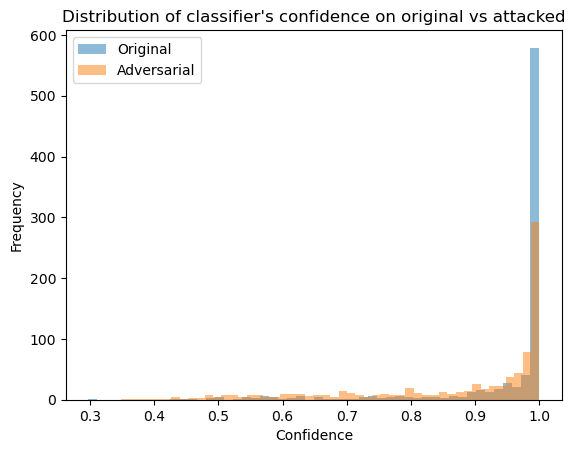

In [122]:
import matplotlib.pyplot as plt

kwargs = dict(alpha=0.5, bins=50)
plt.hist(orig, **kwargs, label='Original')
plt.hist(att, **kwargs, label='Adversarial')
plt.gca().set(title='Distribution of classifier\'s confidence on original vs attacked', ylabel='Frequency', xlabel='Confidence')
plt.legend();